In [1]:
from datetime import date, datetime
from os import listdir
from os.path import isfile, join

from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers

Using TensorFlow backend.
E:\.conda\envs\kerastf114\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\.conda\envs\kerastf114\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\.conda\envs\kerastf114\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\.conda\envs\kerastf114\lib\site-packages\tensorflow\python\framework\dtype

# Read Features

In [2]:
#input variables

c_values = [8] 
q_values = [0.02]
nr_iterations_in_sample = [10]
n_value = 1000

#dates for feature files:
dates = ['2021-01-27']

val_fraction = 0.2
test_fraction = 0.2

batch_size = 256
layer_sizes = [8, 16, 32, 64, 128]
number_layers = [5]
num_epochs = 50


In [3]:
#Read distance and b tracks

all_distance_tracks = {(c,q) : np.array([]) for c in c_values for q in q_values}
all_b_tracks = {(c,q) : np.array([]) for c in c_values for q in q_values}

b_files_folder = '../b_files/'
allfiles = [f for f in listdir(b_files_folder) if isfile(join(b_files_folder, f))]

for f_string in allfiles:
    f_string_split = f_string.split('_')
    
    #Filter out all the files that we don't need:
    if not len(f_string_split) == 6 or not 'c' in f_string_split[3]:
        continue
        
    n = int(f_string_split[2][1:])
    c = int(f_string_split[3][1:])
    q = float(f_string_split[4][1:])
    date = f_string_split[5][:-4]
    
    
    
    if not n == n_value:
        print(f'skip {f_string_split} because n is ', n)
        continue
        
    if not c in c_values:
        print(f'skip {f_string_split} because c is ', c)
        continue
        
    if not q  in q_values:
        print(f'skip {f_string_split} because q is ', q)
        continue
        
    if not date in dates:
        print(f'skip {f_string_split} because date is ', date)
        continue
        
    print(n,c,q,date)
    
    if f_string_split[0] == 'distance':
        distance_track_file = open(b_files_folder + f_string,'r')
        lines = [line.split() for line in distance_track_file.readlines()]
        distance_tracks = np.array([[float(value_string) for value_string in line] for line in lines])
        all_distance_tracks[c,q] = np.concatenate((all_distance_tracks[c,q], distance_tracks))

        
    if f_string_split[0] == 'b':
        b_track_file = open(b_files_folder + f_string,'r')
        lines = [line.split() for line in b_track_file.readlines()]
        b_tracks = np.array([[float(value_string) for value_string in line] for line in lines])
        all_b_tracks[c,q] = np.concatenate((all_b_tracks[c,q], b_tracks))

1000 8 0.02 2021-01-27
1000 8 0.02 2021-01-27


In [4]:
for c in c_values:
    for q in q_values:
        print(c, q, all_b_tracks[c,q].shape, all_distance_tracks[c,q].shape)

8 0.02 (80000,) (80000,)


In [5]:
def create_sample_target_upper_lower(distance_track, b_track, nr_it):
    '''returns:
        - the second up to nr_it value of distance track.   First value is ignored since it is always zero.
        - the first up to nr_it value of b track.           First value is ignored since it is always n.
        - Also the last entry is returned, since that is the actual shortest path.
    '''
    assert len(distance_track) > nr_it


    for i in range(1,nr_it):
        if b_track[i] == b_track[0]:
            b_track[i] = 0
    return distance_track[1:nr_it] + b_track[1:nr_it] , distance_track[-1]
    
def create_samples_targets_upper_lower(distance_tracks, b_tracks, nr_it):
    samples = []
    targets = []
    for i in range(len(distance_tracks)):    
        if len(distance_tracks[i]) > nr_it:
            sample, target = create_sample_target_upper_lower(distance_tracks[i], b_tracks[i], nr_it)
            samples += [sample]
            targets += [target]

        
    samples = np.array(samples)
    targets = np.array(targets)
    return samples, targets

samples = np.empty((0, 2*(nr_iterations_in_sample[0]-1)))
targets = np.empty(0)

for c in c_values:
    for q in q_values: 
        print(c,q)
        samples_cq, targets_cq = create_samples_targets_upper_lower(all_distance_tracks[c,q], all_b_tracks[c,q], nr_iterations_in_sample[0])
        samples = np.concatenate((samples, samples_cq))
        targets = np.concatenate((targets, targets_cq))

print('Shape of samples: ', samples.shape)
print('Shape of targets: ', targets.shape)
            

8 0.02
Shape of samples:  (80000, 18)
Shape of targets:  (80000,)


# Split and normalize

In [6]:
X = samples
Y = targets

X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, 
                                                            Y, 
                                                            test_size=(val_fraction + test_fraction), 
                                                            random_state=1)

X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, 
                                                Y_val_test, 
                                                test_size=test_fraction/(val_fraction + test_fraction), 
                                                random_state=1)



In [7]:
def normalize(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    sample_means = X_train.mean(axis = 0)
    sample_stds = X_train.std(axis = 0)
    
    
    target_mean = Y_train.mean()
    target_std = Y_train.std()
    
    #obtain nr_of_iterations in one sample, take into consideration that there is an ub and lb for each iteration
    nr_it = len(X_train[0])/2
    
    sample_stds[sample_stds==0.0] = 1.0
    assert not target_std == 0.0
    
    X_train_norm  = X_train - sample_means
    X_train_norm /= sample_stds
    X_val_norm    = X_val - sample_means
    X_val_norm   /= sample_stds
    X_test_norm   = X_test - sample_means
    X_test_norm  /= sample_stds
    
    Y_train_norm  = Y_train - target_mean
    Y_train_norm /= target_std
    Y_val_norm    = Y_val - target_mean
    Y_val_norm   /= target_std
    Y_test_norm   = Y_test - target_mean
    Y_test_norm  /= target_std
    return X_train_norm, Y_train_norm, X_val_norm, Y_val_norm, X_test_norm, Y_test_norm,sample_means, sample_stds, target_mean, target_std

In [8]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, sample_means, sample_stds, target_mean, target_std = normalize(X_train,Y_train, X_val, Y_val, X_test, Y_test)

# Create Pipeline

In [9]:
def build_regression_model(nr_nodes, input_shape, n_layers):
    model = models.Sequential()
    model.add(layers.Dense(nr_nodes, activation='relu', input_shape=input_shape))
    for _ in range(n_layers-1):
        model.add(layers.Dense(nr_nodes, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model

In [10]:
def smooth_curve(points, factor=0.8): 
    smoothed_points = [] 
    for point in points: 
        if smoothed_points: 
            previous = smoothed_points[-1] 
            smoothed_points.append(previous * factor + point * (1 - factor))
        else: 
            smoothed_points.append(point)
    return smoothed_points


Train on 48000 samples, validate on 16000 samples
Epoch 1/50
48000/48000 [==============================] - 2s 44us/step - loss: 0.6305 - mae: 0.6142 - val_loss: 0.3490 - val_mae: 0.4843
Epoch 2/50
48000/48000 [==============================] - 3s 56us/step - loss: 0.3223 - mae: 0.4630 - val_loss: 0.3049 - val_mae: 0.4487
Epoch 3/50
48000/48000 [==============================] - 2s 52us/step - loss: 0.2906 - mae: 0.4367 - val_loss: 0.2780 - val_mae: 0.4251
Epoch 4/50
48000/48000 [==============================] - 3s 52us/step - loss: 0.2684 - mae: 0.4157 - val_loss: 0.2614 - val_mae: 0.4071
Epoch 5/50
48000/48000 [==============================] - 2s 51us/step - loss: 0.2539 - mae: 0.4002 - val_loss: 0.2470 - val_mae: 0.3924
Epoch 6/50
48000/48000 [==============================] - 3s 60us/step - loss: 0.2442 - mae: 0.3888 - val_loss: 0.2409 - val_mae: 0.3861
Epoch 7/50
48000/48000 [==============================] - 3s 59us/step - loss: 0.2372 - mae: 0.3806 - val_loss: 0.2342 - val_ma

48000/48000 [==============================] - 2s 51us/step - loss: 0.2244 - mae: 0.3653 - val_loss: 0.2237 - val_mae: 0.3649
Epoch 9/50
48000/48000 [==============================] - 2s 50us/step - loss: 0.2211 - mae: 0.3609 - val_loss: 0.2266 - val_mae: 0.3634
Epoch 10/50
48000/48000 [==============================] - 2s 47us/step - loss: 0.2193 - mae: 0.3583 - val_loss: 0.2169 - val_mae: 0.3552
Epoch 11/50
48000/48000 [==============================] - 2s 49us/step - loss: 0.2162 - mae: 0.3546 - val_loss: 0.2122 - val_mae: 0.3512
Epoch 12/50
48000/48000 [==============================] - 2s 36us/step - loss: 0.2145 - mae: 0.3521 - val_loss: 0.2114 - val_mae: 0.3506
Epoch 13/50
48000/48000 [==============================] - 2s 39us/step - loss: 0.2126 - mae: 0.3496 - val_loss: 0.2132 - val_mae: 0.3494
Epoch 14/50
48000/48000 [==============================] - 2s 42us/step - loss: 0.2106 - mae: 0.3465 - val_loss: 0.2112 - val_mae: 0.3469
Epoch 15/50
48000/48000 [======================

48000/48000 [==============================] - 2s 34us/step - loss: 0.2036 - mae: 0.3354 - val_loss: 0.2063 - val_mae: 0.3355
Epoch 18/50
48000/48000 [==============================] - 2s 41us/step - loss: 0.2030 - mae: 0.3351 - val_loss: 0.2027 - val_mae: 0.3329
Epoch 19/50
48000/48000 [==============================] - 2s 32us/step - loss: 0.2030 - mae: 0.3349 - val_loss: 0.2040 - val_mae: 0.3370
Epoch 20/50
48000/48000 [==============================] - 3s 56us/step - loss: 0.2026 - mae: 0.3345 - val_loss: 0.2056 - val_mae: 0.3372
Epoch 21/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.2027 - mae: 0.3337 - val_loss: 0.2081 - val_mae: 0.3388
Epoch 22/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.2024 - mae: 0.3343 - val_loss: 0.2030 - val_mae: 0.3385
Epoch 23/50
48000/48000 [==============================] - 3s 56us/step - loss: 0.2016 - mae: 0.3335 - val_loss: 0.2044 - val_mae: 0.3341
Epoch 24/50
48000/48000 [=====================

48000/48000 [==============================] - 3s 54us/step - loss: 0.1982 - mae: 0.3297 - val_loss: 0.2054 - val_mae: 0.3334
Epoch 27/50
48000/48000 [==============================] - 3s 53us/step - loss: 0.1980 - mae: 0.3294 - val_loss: 0.2004 - val_mae: 0.3296
Epoch 28/50
48000/48000 [==============================] - 2s 46us/step - loss: 0.1978 - mae: 0.3288 - val_loss: 0.2041 - val_mae: 0.3337
Epoch 29/50
48000/48000 [==============================] - 2s 50us/step - loss: 0.1971 - mae: 0.3286 - val_loss: 0.2030 - val_mae: 0.3370
Epoch 30/50
48000/48000 [==============================] - 2s 39us/step - loss: 0.1970 - mae: 0.3283 - val_loss: 0.2029 - val_mae: 0.3339
Epoch 31/50
48000/48000 [==============================] - 2s 33us/step - loss: 0.1964 - mae: 0.3277 - val_loss: 0.2084 - val_mae: 0.3375
Epoch 32/50
48000/48000 [==============================] - 1s 29us/step - loss: 0.1963 - mae: 0.3278 - val_loss: 0.2084 - val_mae: 0.3359
Epoch 33/50
48000/48000 [=====================

48000/48000 [==============================] - 2s 49us/step - loss: 0.1831 - mae: 0.3117 - val_loss: 0.2007 - val_mae: 0.3305
Epoch 36/50
48000/48000 [==============================] - 2s 32us/step - loss: 0.1821 - mae: 0.3106 - val_loss: 0.2022 - val_mae: 0.3296
Epoch 37/50
48000/48000 [==============================] - 3s 54us/step - loss: 0.1813 - mae: 0.3096 - val_loss: 0.1997 - val_mae: 0.3270
Epoch 38/50
48000/48000 [==============================] - 2s 51us/step - loss: 0.1794 - mae: 0.3076 - val_loss: 0.1983 - val_mae: 0.3262
Epoch 39/50
48000/48000 [==============================] - 3s 53us/step - loss: 0.1785 - mae: 0.3065 - val_loss: 0.2023 - val_mae: 0.3332
Epoch 40/50
48000/48000 [==============================] - 3s 53us/step - loss: 0.1779 - mae: 0.3052 - val_loss: 0.1983 - val_mae: 0.3261
Epoch 41/50
48000/48000 [==============================] - 2s 44us/step - loss: 0.1765 - mae: 0.3037 - val_loss: 0.2005 - val_mae: 0.3262
Epoch 42/50
48000/48000 [=====================

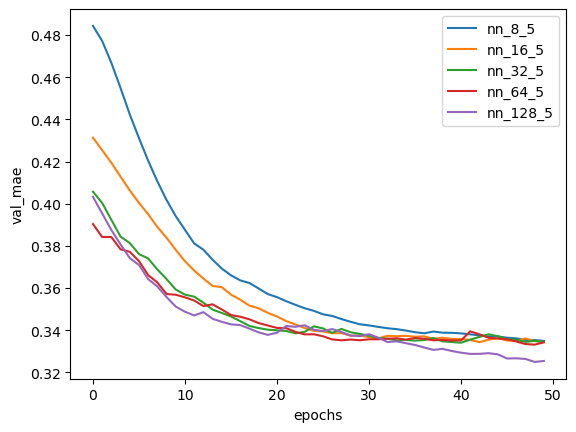

In [11]:
nn_models = []
model_names = []

show_plot = True
for layer_size in layer_sizes:
    for n_layers in number_layers:
        nn = build_regression_model(layer_size, X_train[0].shape, n_layers)
    
        history = nn.fit(X_train, Y_train, validation_data =(X_val, Y_val), epochs=num_epochs, batch_size=batch_size)
        
        name = "nn_" + str(layer_size) + "_" + str(n_layers)
        if show_plot:
            plt.plot(smooth_curve(history.history['val_mae']), label=name)
        nn_models += [nn]
        model_names += [name]

if show_plot:
    plt.xlabel('epochs')
    plt.ylabel('val_mae')
    plt.legend()
    plt.show()

In [12]:
def test_prediction_method(y_train, y_train_pred, y_val, y_val_pred, name):
    mse = mean_squared_error(y_train, y_train_pred)
    mae = mean_absolute_error(y_train, y_train_pred)
    mape = mean_absolute_percentage_error(y_train, y_train_pred)
   
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    
    string = f'{name}\t{mse:.4f}\t{mae:.4f}\t{mape:.4f}\t\t{val_mse:.4f}\t{val_mae:.4f}\t{val_mape:.4f}'
    print(string)

In [13]:
print(f'name\tmse\tmae\tmape\t\tval_mse\tval_mae\tval_mape')
for model, name in zip(nn_models, model_names):
    Y_train_pred = nn.predict(X_train)
    Y_val_pred = nn.predict(X_val)
    test_prediction_method(Y_train, Y_train_pred, Y_val, Y_val_pred, name)

name	mse	mae	mape		val_mse	val_mae	val_mape
nn_8_5	0.1680	0.2955	1.7825		0.1991	0.3273	2.4971
nn_16_5	0.1680	0.2955	1.7825		0.1991	0.3273	2.4971
nn_32_5	0.1680	0.2955	1.7825		0.1991	0.3273	2.4971
nn_64_5	0.1680	0.2955	1.7825		0.1991	0.3273	2.4971
nn_128_5	0.1680	0.2955	1.7825		0.1991	0.3273	2.4971


In [14]:
for i, name in enumerate(model_names):
    print(i, name)

0 nn_8_5
1 nn_16_5
2 nn_32_5
3 nn_64_5
4 nn_128_5


In [15]:
def output_scaling_info(datestring, model_name, sample_means, sample_stds, target_mean, target_std, i0):
    with open(f"../models/info_{model_name}_based_on_{datestring}.txt", "w") as infofile:
        
        for i in range(len(sample_means)):
            infofile.write(f"{sample_means[i]}\n")
        infofile.write("---\n")
        for i in range(len(sample_stds)):
            infofile.write(f"{sample_stds[i]}\n")
        infofile.write("---\n")
        infofile.write(f"{target_mean}\n")
        infofile.write("---\n")
        infofile.write(f"{target_std}\n")
        infofile.write("---\n")
        infofile.write(f"{i0}\n")
        infofile.write("---\n")

        
def save_nn(datestring, model_name, model):
    model.save(f"../models/{model_name}_based_on_{datestring}.h5", include_optimizer=False)
    print("Saved model to disk")

In [16]:
#Save models and modelinfo for using it in CPP
models_to_save = [0]

for i in models_to_save:
    
    nn = nn_models[i]
    name = model_names[i]
    
    output_scaling_info(dates[0], name, sample_means, sample_stds, target_mean, target_std, 10)
    save_nn(dates[0], name, nn)

Saved model to disk
